In [1]:
import os, json, pprint, re
from collections import defaultdict
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
root_path = os.path.dirname(os.getcwd())
root_path

'C:\\Users\\david\\Projects\\epfl-pdm'

In [3]:
data_path = os.path.join(root_path, "data")
data_path

'C:\\Users\\david\\Projects\\epfl-pdm\\data'

In [4]:
raw_path = os.path.join(data_path, "raw")
raw_path

'C:\\Users\\david\\Projects\\epfl-pdm\\data\\raw'

In [5]:
clean_path = os.path.join(data_path, "clean")
clean_path

'C:\\Users\\david\\Projects\\epfl-pdm\\data\\clean'

In [6]:
group_paths = os.listdir(raw_path)
group_paths

['David', 'Gr1', 'Gr2', 'Gr3', 'Gr4', 'Gr5']

In [7]:
for p in group_paths:
    print(os.listdir(os.path.join(raw_path, p)))

['activity1-truncated.txt', 'activity2.txt', 'activity3.txt']
['aufgabe1.log', 'aufgabe2.log', 'aufgabe3.log']
['aufgabe1.log', 'aufgabe2.log', 'aufgabe3.log']
['aufgabe1.log', 'aufgabe2.log', 'aufgabe3.log']
['aufgabe1.log', 'aufgabe2.log', 'aufgabe3.log']
['Aufgabe I + II.log', 'Aufgabe I.log', 'Aufgabe III.log']


In [8]:
# Quickly replace multiple strings based on a dict
def replace_all(string, table):
    for k, v in table.items():
        string = string.replace(k, v)
    return string

# Non tail-recursive flatten operation
def flatten(original):
    entry = original.copy()
    children = entry.get("children")
    ret = [entry]
    
    if children:
        entry.pop("children")
        
        for c in children:
            ret += flatten(c)
            
    return ret

In [9]:
replacements = {
    "beers-law-lab_en-phetio.html?phetioStandalone&phetioLog=console:983 ": "\u200b",
    "[Intervention] Unable to preventDefault inside passive event listener due to target being treated as passive. See <URL>": ""
}

In [10]:
data = {}
temp = {}

for p in group_paths:
    sub_data = {}
    sub_temp = {}
    
    sub_path = os.path.join(raw_path, p)
    for i, sub_p in enumerate(os.listdir(sub_path)):
        batch = []
        batch_temp = []
        
        with open(os.path.join(sub_path, sub_p), "r", encoding="utf-8") as f:
            raw = replace_all(f.read(), replacements).split("\u200b")[1:]
            print("Raw entries in", p, sub_p, ":", len(raw))
            
            for elem in raw:
                try:
                    batch += flatten(json.loads(elem))
                    batch_temp += [json.loads(elem)]
                except Exception as e:
                    print("\tDropped 1 invalid element")
                    
            print("\tFlattened entries :", len(batch))
        
        sub_data[i] = batch
        sub_temp[i] = batch_temp
        
    data[p] = sub_data
    temp[p] = sub_temp

Raw entries in David activity1-truncated.txt : 1000
	Flattened entries : 3083
Raw entries in David activity2.txt : 0
	Flattened entries : 0
Raw entries in David activity3.txt : 0
	Flattened entries : 0
Raw entries in Gr1 aufgabe1.log : 1000
	Flattened entries : 2714
Raw entries in Gr1 aufgabe2.log : 1000
	Flattened entries : 2595
Raw entries in Gr1 aufgabe3.log : 1000
	Flattened entries : 2557
Raw entries in Gr2 aufgabe1.log : 607
	Flattened entries : 1512
Raw entries in Gr2 aufgabe2.log : 1000
	Flattened entries : 3200
Raw entries in Gr2 aufgabe3.log : 1000
	Flattened entries : 3074
Raw entries in Gr3 aufgabe1.log : 743
	Flattened entries : 1869
Raw entries in Gr3 aufgabe2.log : 1000
	Flattened entries : 3025
Raw entries in Gr3 aufgabe3.log : 510
	Flattened entries : 1393
Raw entries in Gr4 aufgabe1.log : 1000
	Flattened entries : 3290
Raw entries in Gr4 aufgabe2.log : 3302
	Flattened entries : 10333
Raw entries in Gr4 aufgabe3.log : 4453
	Dropped 1 invalid element
	Flattened entries 

In [11]:
for k in data.keys():
    for k2 in data[k]:
        print(k, k2, len(data[k][k2]))

David 0 3083
David 1 0
David 2 0
Gr1 0 2714
Gr1 1 2595
Gr1 2 2557
Gr2 0 1512
Gr2 1 3200
Gr2 2 3074
Gr3 0 1869
Gr3 1 3025
Gr3 2 1393
Gr4 0 3290
Gr4 1 10333
Gr4 2 13239
Gr5 0 2897
Gr5 1 1970
Gr5 2 2526


In [12]:
comps = {}

for e in data["Gr4"][2]:
    ct = e["componentType"]
    comps[ct] = comps.get(ct, 0) + 1
    
comps

{'TTandemDragHandler': 4159,
 'TProperty': 3363,
 'TRadioButton': 12,
 'TTandemText': 2938,
 'TDerivedProperty': 2486,
 'TComboBox': 52,
 'TToggleButton': 6,
 'TPushButton': 223}

In [13]:
cts, evs, pids = set(), set(), set()
gen = ((d["componentType"], d["event"], d["phetioID"]) for k in data for k2 in data[k] for d in data[k][k2])
d = defaultdict(dict)

for c, b, a in gen:
    try:
        d[c][a] = list(set(d[c][a] + [b]))
    except:
        d[c][a] = [b]

categories = d
pprint.pprint(categories)

defaultdict(<class 'dict'>,
            {'TComboBox': {'beersLawLab.beersLawScreen.view.solutionControls.comboBox': ['popupHidden',
                                                                                         'popupShown',
                                                                                         'fired']},
             'TDerivedProperty': {'beersLawLab.beersLawScreen.model.detector.valueProperty': ['changed']},
             'TProperty': {'beersLawLab.beersLawScreen.model.cuvette.widthProperty': ['changed'],
                           'beersLawLab.beersLawScreen.model.detector.modeProperty': ['changed'],
                           'beersLawLab.beersLawScreen.model.detector.probe.locationProperty': ['changed'],
                           'beersLawLab.beersLawScreen.model.light.onProperty': ['changed'],
                           'beersLawLab.beersLawScreen.model.light.wavelengthProperty': ['changed'],
                           'beersLawLab.beersLawScreen.model

In [14]:
gen = ((k, k2, k3) for k in categories for k2 in categories[k] for k3 in categories[k][k2])
list(gen)

[('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener',
  'dragged'),
 ('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener',
  'dragEnded'),
 ('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener',
  'dragStarted'),
 ('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler',
  'dragged'),
 ('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler',
  'dragEnded'),
 ('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler',
  'dragStarted'),
 ('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler',
  'dragged'),
 ('TTandemDragHandler',
  'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler',
  'dragEnded'),
 (

In [15]:
gen = ((k, k2, k3) for k in categories for k2 in categories[k] for k3 in categories[k][k2])
d = {}

for cType, _, event in gen:
    try:
        d[event] = list(set(d[event] + [cType]))
    except:
        d[event] = [cType]
        
pprint.pprint(d)

{'changed': ['TDerivedProperty', 'TProperty'],
 'dragEnded': ['TTandemDragHandler'],
 'dragStarted': ['TTandemDragHandler'],
 'dragged': ['TTandemDragHandler'],
 'fired': ['TPushButton', 'TRadioButton', 'TComboBox', 'TScreenButton'],
 'popupHidden': ['TComboBox'],
 'popupShown': ['TComboBox'],
 'simStarted': ['TSim'],
 'textChanged': ['TTandemText'],
 'toggled': ['TToggleButton']}


In [16]:
gen = ((k, k2, k3) for k in categories for k2 in categories[k] for k3 in categories[k][k2])
d = {}

for cType, phetioID, _ in gen:
    try:
        d[cType] = list(set(d[cType] + [phetioID]))
    except:
        d[cType] = [phetioID]
        
pprint.pprint(d)

{'TComboBox': ['beersLawLab.beersLawScreen.view.solutionControls.comboBox'],
 'TDerivedProperty': ['beersLawLab.beersLawScreen.model.detector.valueProperty'],
 'TProperty': ['beersLawLab.beersLawScreen.model.cuvette.widthProperty',
               'beersLawLab.beersLawScreen.solutions.potassiumDichromate.concentrationProperty',
               'beersLawLab.beersLawScreen.solutions.potassiumPermanganate.concentrationProperty',
               'beersLawLab.beersLawScreen.solutions.drinkMix.concentrationProperty',
               'beersLawLab.beersLawScreen.model.solutionProperty',
               'beersLawLab.beersLawScreen.model.detector.probe.locationProperty',
               'beersLawLab.beersLawScreen.model.light.wavelengthProperty',
               'beersLawLab.sim.showHomeScreenProperty',
               'beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthProperty',
               'beersLawLab.beersLawScreen.solutions.cobaltIINitrate.concentrationProperty',
             

In [17]:
# For 'TTandemDragHandler'
def getDragHandler(df, pid):
    # Filter on property
    df = df[df["phetioID"] == pid]
    
    # Filter on property
    df = df[df["phetioID"] == pid]
    
    # Exit if property absent
    if len(df) == 0:
        return None
    
    # Index on time
    df.set_index("time", inplace=True)
    
    # Remove unwanted columns
    df = df["parameters"].apply(pd.Series)
    
    return df[["x", "y"]]

# For 'TProperty' and 'TDerivedProperty'
def getProperty(df, pid):
    # Get start time
    init_time = df.loc[0]["time"]
    
    # Filter on property
    df = df[df["phetioID"] == pid]
    
    # Exit if property absent
    if len(df) == 0:
        return None
    
    # Index on time
    df.set_index("time", inplace=True)
    
    # Remove unwanted columns
    df = df["parameters"].apply(pd.Series)
    init_val = df.iloc[0]["oldValue"]
    df = df["newValue"]
    
    try:
        # Add starting value
        df.loc[init_time] = init_val
    except:
        pass
        # THIS IS TEMPORARY; THERE IS A BUG HERE
    
    return df.sort_index()

# For 'TToggleButton'
def getToggle(df, pid):
    return getProperty(df, pid).astype(int)

# For 'TPushButton', 'TRadioButton', 'TComboBox', 'TScreenButton', 'TTandemText' and 'TComboBox'
# FUTURE : EXTEND TO PLUS/MINUS BUTTONS
def getButton(df, pid):
    
    # Filter on property
    df = df[df["phetioID"] == pid]
    
    # Exit if property absent
    if len(df) == 0:
        return None
    
    # Index on time
    df.set_index("time", inplace=True)
    
    # Remove unwanted columns
    return df["event"]

def processComp(df, cType, pid):
    if cType == 'TTandemDragHandler':
        return getDragHandler(df, pid)
    elif cType == 'TToggleButton':
        return getToggle(df, pid)
    elif "Property" in cType:
        return getProperty(df, pid)
    else:
        return getButton(df, pid)

def processLog(df):
    uniques = df[["componentType", "phetioID"]].drop_duplicates()

In [18]:
df = pd.DataFrame(data["Gr4"][2])
df[df["event"] == "model"]

,messageIndex,eventType,phetioID,componentType,event,time,parameters


In [19]:
df = pd.DataFrame(data["Gr4"][2])
u = df[["componentType", "phetioID"]].drop_duplicates()
ts = {}

for _, row in u.iterrows():
    name = row["phetioID"]
    ts[name] = processComp(df, row["componentType"], name)

beersLawLab.beersLawScreen.model.detector.probe.locationProperty
beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthRadioButton
beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthProperty
beersLawLab.beersLawScreen.view.wavelengthControls.valueDisplay
beersLawLab.beersLawScreen.view.detectorNode.bodyNode.valueNode
beersLawLab.beersLawScreen.view.solutionControls.comboBox
beersLawLab.beersLawScreen.model.solutionProperty
beersLawLab.beersLawScreen.model.ruler.locationProperty
beersLawLab.beersLawScreen.view.wavelengthControls.presetWavelengthRadioButton
beersLawLab.beersLawScreen.model.light.onProperty
beersLawLab.beersLawScreen.view.detectorNode.bodyNode.transmittanceRadioButton
beersLawLab.beersLawScreen.model.detector.modeProperty
beersLawLab.beersLawScreen.view.detectorNode.bodyNode.absorbanceRadioButton
beersLawLab.beersLawScreen.view.resetAllButton
beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.minusButton
beersLawLab.beersL

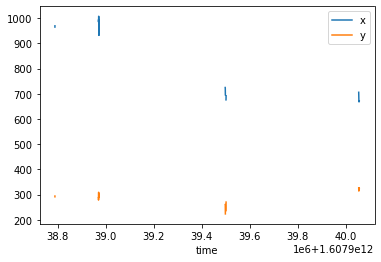

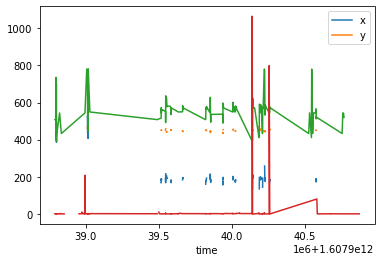

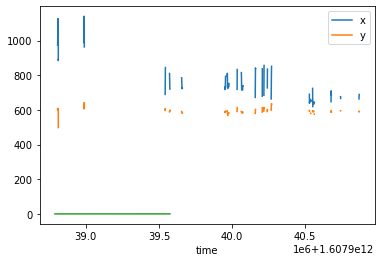

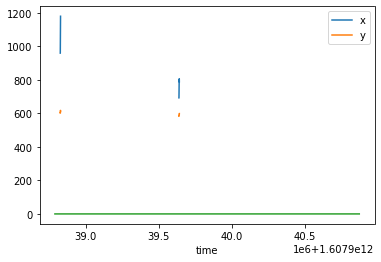

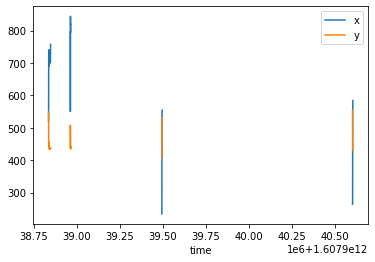

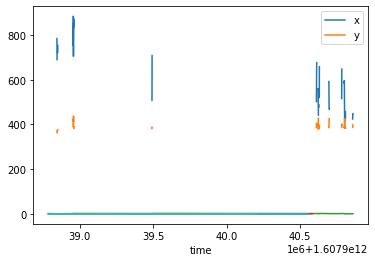

In [20]:
for name, t in ts.items():
    try:
        t.plot()
    except:
        print(name)

In [21]:
ts.keys()

dict_keys(['beersLawLab.beersLawScreen.view.detectorNode.probeNode.movableDragHandler', 'beersLawLab.beersLawScreen.model.detector.probe.locationProperty', 'beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthRadioButton', 'beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthProperty', 'beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener', 'beersLawLab.beersLawScreen.model.light.wavelengthProperty', 'beersLawLab.beersLawScreen.view.wavelengthControls.valueDisplay', 'beersLawLab.beersLawScreen.model.detector.valueProperty', 'beersLawLab.beersLawScreen.view.detectorNode.bodyNode.valueNode', 'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'beersLawLab.beersLawScreen.solutions.drinkMix.concentrationProperty', 'beersLawLab.beersLawScreen.view.solutionControls.comboBox', 'beersLawLab.beersLawScreen.model.solutionProperty', 'beersLawLab.beersLawScreen.view.solutionControls.co

## TURN LASER ON / OFF

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.lightNode.button",
"componentType": "TToggleButton",
"event": "toggled"

LASER LIGHT (PASSIVE)

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.light.onProperty",
"componentType": "TProperty",
"event": "changed"

TRANSMITTANCE / ABSORBANCE INTERNAL VALUE (PASSIVE)

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.detector.valueProperty",
"componentType": "TDerivedProperty",
"event": "changed"

TRANSMITTANCE / ABSORBANCE DISPLAY (PASSIVE)

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.view.detectorNode.bodyNode.valueNode",
"componentType": "TTandemText",
"event": "textChanged"

## SWITCH TRANSMITTANCE / ABSORBANCE

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.detectorNode.bodyNode.transmittanceRadioButton",
OR
"phetioID": "beersLawLab.beersLawScreen.view.detectorNode.bodyNode.absorbanceRadioButton",
"componentType": "TRadioButton",
"event": "fired",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.detector.modeProperty",
"componentType": "TProperty",
"event": "changed",

## SWITCH PRESET / VARIABLE

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.presetWavelengthRadioButton",
OR
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthRadioButton",
"componentType": "TRadioButton",
"event": "fired",

INTERNAL PROPERTY (PASSIVE)

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.variableWavelengthProperty",
"componentType": "TProperty",
"event": "changed",

## TWEAK WAVELENGTH

### SLIDER

#### DRAG START

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener",
"componentType": "TTandemDragHandler",
"event": "dragStarted",

#### DRAG

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener",
"componentType": "TTandemDragHandler",
"event": "dragged",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.light.wavelengthProperty",
"componentType": "TProperty",
"event": "changed",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.valueDisplay",
"componentType": "TTandemText",
"event": "textChanged",

#### DRAG END

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.thumbInputListener",
"componentType": "TTandemDragHandler",
"event": "dragEnded"

### BUTTONS

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.plusButton",
OR
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.wavelengthSlider.minusButton",
"componentType": "TPushButton",
"event": "fired",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.light.wavelengthProperty",
"componentType": "TProperty",
"event": "changed",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.valueDisplay",
"componentType": "TTandemText",
"event": "textChanged",

## MOVE RULER

### DRAG START

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.rulerNode.movableDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragStarted",

### DRAG

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.rulerNode.movableDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragged",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.ruler.locationProperty",
"componentType": "TProperty",
"event": "changed",

### DRAG END

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.rulerNode.movableDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragEnded",

## RESIZE CONTAINER

### DRAG START

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragStarted",

### DRAG

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragged",

### DRAG END

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.cuvetteNode.cuvetteDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragEnded",

## MOVE PROBE

### DRAG START

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.detectorNode.probeNode.movableDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragStarted",

### DRAG

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.detectorNode.probeNode.movableDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragged",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.detector.probe.locationProperty",
"componentType": "TProperty",
"event": "changed",

### DRAG END

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.detectorNode.probeNode.movableDragHandler",
"componentType": "TTandemDragHandler",
"event": "dragEnded",

### WHEN SNAP FOLLOWED BY

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.detector.probe.locationProperty",
"componentType": "TProperty",
"event": "changed",

With property y = 2

In [22]:
[
    "solution-open" : [{
        "pid" : ["view", "solutionControls", "comboBox"],
        "evt" : "popupShown",
    }],
    "solution-close" : [{
        "pid" : ["view", "solutionControls", "comboBox"],
        "evt" : "popupHidden",
    }],
]

[{'pid': ['view', 'solutionControls', 'comboBox'], 'evt': 'popupShown'}]

## SOLUTION SELECTION

### OPEN

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.comboBox",
"componentType": "TComboBox",
"event": "popupShown",

### CLOSE

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.comboBox",
"componentType": "TComboBox",
"event": "popupHidden",

### CHOOSE

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.comboBox",
"componentType": "TComboBox",
"event": "fired",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.solutionProperty",
"componentType": "TProperty",
"event": "changed",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.model.light.wavelengthProperty",
"componentType": "TProperty",
"event": "changed",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.view.wavelengthControls.valueDisplay",
"componentType": "TTandemText",
"event": "textChanged",

## TWEAK CONCENTRATION

### SLIDER

#### DRAG START

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler",
"componentType": "TTandemDragHandler",
"event": "dragStarted",

#### DRAG

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler",
"componentType": "TTandemDragHandler",
"event": "dragged",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.solutions.cobaltChloride.concentrationProperty",
"componentType": "TProperty",
"event": "changed",

#### DRAG END

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler",
"componentType": "TTandemDragHandler",
"event": "dragEnded",

### BUTTONS

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.plusButton",
OR
"phetioID": "beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.minusButton",
"componentType": "TPushButton",
"event": "fired",

"eventType": "model",
"phetioID": "beersLawLab.beersLawScreen.solutions.cobaltChloride.concentrationProperty",
"componentType": "TProperty",
"event": "changed",

## RESET

"eventType": "user",
"phetioID": "beersLawLab.beersLawScreen.view.resetAllButton",
"componentType": "TPushButton",
"event": "fired",

On doit définir :
- Quand la sonde est à droite / dans / à gauche du bécher
- Quand la sonde est en dessus / dans / en dessous du laser

On ignore les autres logs qui sont des changements de sim etc, toutes facons la sim garde son état.

In [23]:
states = {
    "laser" : ["on", "off"],
    "wavelength" : None, # Linear value
    "container" : None, # Linear value
    "probe" : ([0-1], [0-1]), # Linear for position and binary for laser contact
    "mode" : ["transmittance", "absorbance"],
    "solution" : ["drink", "cono32", "cocl2", "k2cr2o7", "k2cro4", "nicl2", "cuso4", "kmno4"], # Color according to beverage color
    "concentration" : None, # Linear value
    "ruler" : None, # Distance to container
    "resetter" : ["on", "off"],
}

# utiliser le old_value pour set la valeur à 0

In [24]:
for k in ts.keys():
    print(k.split(".")[2:])

['view', 'detectorNode', 'probeNode', 'movableDragHandler']
['model', 'detector', 'probe', 'locationProperty']
['view', 'wavelengthControls', 'variableWavelengthRadioButton']
['view', 'wavelengthControls', 'variableWavelengthProperty']
['view', 'wavelengthControls', 'wavelengthSlider', 'thumbInputListener']
['model', 'light', 'wavelengthProperty']
['view', 'wavelengthControls', 'valueDisplay']
['model', 'detector', 'valueProperty']
['view', 'detectorNode', 'bodyNode', 'valueNode']
['view', 'solutionControls', 'concentrationControl', 'slider', 'thumb', 'dragHandler']
['solutions', 'drinkMix', 'concentrationProperty']
['view', 'solutionControls', 'comboBox']
['model', 'solutionProperty']
['view', 'solutionControls', 'concentrationControl', 'slider', 'track', 'inputListener']
['solutions', 'potassiumPermanganate', 'concentrationProperty']
['view', 'rulerNode', 'movableDragHandler']
['model', 'ruler', 'locationProperty']
['view', 'cuvetteNode', 'cuvetteDragHandler']
['model', 'cuvette', 'w

In [81]:
chunks = [[s for s in flatten(f)] for f in temp["Gr1"][1]]
len(chunks)

#[".".join(s["phetioID"].split(".")[2:])

1000

In [89]:
def get_chunk_data(chunk):
    return [((".".join(e["phetioID"].split(".")[2:]), e["event"]), e.get("parameters")) for e in chunk]

def get_chunk_head(chunk):
    return get_chunk_data(chunk)[0]

In [93]:
for c in chunks:
    mode, data = get_chunk_head(c)
    print(mapper[mode], data)

KeyError: ('view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'dragged')

In [63]:
unique_chunks = []

for c in chunks:
    unseen = True
    data = get_chunk_head(c)
    
    for u in unique_chunks:
        if u == data:
            unseen = False
            break
    
    if unseen:
        unique_chunks.append(data)
        
len(unique_chunks)

17

In [65]:
unique_chunks = []

for i in range(1, 6):
    for j in range(3):
        chunks = [[s for s in flatten(f)] for f in temp["Gr" + str(i)][j]]
        
        for c in chunks:
            unseen = True
            data = get_chunk_head(c)

            for u in unique_chunks:
                if u == data:
                    unseen = False
                    break

            if unseen:
                unique_chunks.append(data)

In [68]:
unique_chunks

[('view.rulerNode.movableDragHandler', 'dragged'),
 ('view.rulerNode.movableDragHandler', 'dragEnded'),
 ('view.lightNode.button', 'toggled'),
 ('view.wavelengthControls.variableWavelengthRadioButton', 'fired'),
 ('view.wavelengthControls.wavelengthSlider.thumbInputListener',
  'dragStarted'),
 ('view.wavelengthControls.wavelengthSlider.thumbInputListener', 'dragged'),
 ('view.wavelengthControls.wavelengthSlider.thumbInputListener', 'dragEnded'),
 ('view.detectorNode.bodyNode.absorbanceRadioButton', 'fired'),
 ('view.solutionControls.comboBox', 'popupShown'),
 ('view.solutionControls.comboBox', 'fired'),
 ('view.solutionControls.concentrationControl.slider.thumb.dragHandler',
  'dragStarted'),
 ('view.solutionControls.concentrationControl.slider.thumb.dragHandler',
  'dragged'),
 ('view.solutionControls.concentrationControl.slider.thumb.dragHandler',
  'dragEnded'),
 ('view.rulerNode.movableDragHandler', 'dragStarted'),
 ('view.cuvetteNode.cuvetteDragHandler', 'dragStarted'),
 ('view.c

In [69]:
with open("entries.txt", "w") as f:
    pprint.pprint({i : e for i, e in enumerate(unique_chunks)}, f)

Simply log what happens first
We'll take care of the numbers later (ask Christian what he thinks)
Just take the first in each batch

In [94]:
actions = {
    "concentration-drag-start":   ('view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'dragStarted'),
    "concentration-drag":         ('view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'dragged'),
    "concentration-drag-end":     ('view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'dragEnded'),
    #"concentration-drag-start":   ('view.solutionControls.concentrationControl.slider.track.inputListener', 'dragStarted'),
    #"concentration-drag":         ('view.solutionControls.concentrationControl.slider.track.inputListener', 'dragged'),
    #"concentration-drag-end":     ('view.solutionControls.concentrationControl.slider.track.inputListener', 'dragEnded'),
    "concentration-plus":         ('view.solutionControls.concentrationControl.slider.plusButton', 'fired'),
    "concentration-minus":        ('view.solutionControls.concentrationControl.slider.minusButton', 'fired'),
    "container-drag-start":       ('view.cuvetteNode.cuvetteDragHandler', 'dragStarted'),
    "container-drag":             ('view.cuvetteNode.cuvetteDragHandler', 'dragged'),
    "container-drag-end":         ('view.cuvetteNode.cuvetteDragHandler', 'dragEnded'),
    "laser-toggle":               ('view.lightNode.button', 'toggled'),
    "probe-toggle-absorbance":    ('view.detectorNode.bodyNode.absorbanceRadioButton', 'fired'),
    "probe-toggle-transmittance": ('view.detectorNode.bodyNode.transmittanceRadioButton', 'fired'),
    "probe-drag-start":           ('view.detectorNode.probeNode.movableDragHandler', 'dragStarted'),
    "probe-drag":                 ('view.detectorNode.probeNode.movableDragHandler', 'dragged'),
    "probe-drag-end":             ('view.detectorNode.probeNode.movableDragHandler', 'dragEnded'),
    "ruler-drag-start":           ('view.rulerNode.movableDragHandler', 'dragStarted'),
    "ruler-drag":                 ('view.rulerNode.movableDragHandler', 'dragged'),
    "ruler-drag-end":             ('view.rulerNode.movableDragHandler', 'dragEnded'),
    "sim-start":                  ('', 'simStarted'),
    "sim-reset":                  ('view.resetAllButton', 'fired'),
    "solution-open":              ('view.solutionControls.comboBox', 'popupShown'),
    "solution-choose":            ('view.solutionControls.comboBox', 'fired'),
    "solution-close":             ('view.solutionControls.comboBox', 'popupHidden'),
    "wavelength-toggle-preset":   ('view.wavelengthControls.presetWavelengthRadioButton', 'fired'),
    "wavelength-toggle-variable": ('view.wavelengthControls.variableWavelengthRadioButton', 'fired'),
    "wavelength-drag-start":      ('view.wavelengthControls.wavelengthSlider.thumbInputListener', 'dragStarted'),
    "wavelength-drag":            ('view.wavelengthControls.wavelengthSlider.thumbInputListener', 'dragged'),
    "wavelength-drag-end":        ('view.wavelengthControls.wavelengthSlider.thumbInputListener', 'dragEnded'),
    "wavelength-drag-start":      ('view.wavelengthControls.wavelengthSlider.trackInputListener', 'dragStarted'),
    "wavelength-drag-end":        ('view.wavelengthControls.wavelengthSlider.trackInputListener', 'dragEnded'),
    "wavelength-plus":            ('view.wavelengthControls.wavelengthSlider.plusButton', 'fired'),
    "wavelength-minus":           ('view.wavelengthControls.wavelengthSlider.minusButton', 'fired'),
    "window-big":                 ('view.beersLawScreenSmallButton', 'fired'),
    "window-small":               ('view.beersLawScreenLargeButton', 'fired'),
}

In [104]:
newmap = dict()

for k, v in mapper.items():
    p1, p2 = k
    newmap.setdefault(p1, {})[p2] = v
    
newmap

{'': {'simStarted': 'sim-start'},
 'view.beersLawScreenLargeButton': {'fired': 'window-small'},
 'view.beersLawScreenSmallButton': {'fired': 'window-big'},
 'view.cuvetteNode.cuvetteDragHandler': {'dragEnded': 'container-drag-end',
  'dragStarted': 'container-drag-start',
  'dragged': 'container-drag'},
 'view.detectorNode.bodyNode.absorbanceRadioButton': {'fired': 'probe-toggle-absorbance'},
 'view.detectorNode.bodyNode.transmittanceRadioButton': {'fired': 'probe-toggle-transmittance'},
 'view.detectorNode.probeNode.movableDragHandler': {'dragEnded': 'probe-drag-end',
  'dragStarted': 'probe-drag-start',
  'dragged': 'probe-drag'},
 'view.lightNode.button': {'toggled': 'laser-toggle'},
 'view.resetAllButton': {'fired': 'sim-reset'},
 'view.rulerNode.movableDragHandler': {'dragEnded': 'ruler-drag-end',
  'dragStarted': 'ruler-drag-start',
  'dragged': 'ruler-drag'},
 'view.solutionControls.comboBox': {'fired': 'solution-choose',
  'popupHidden': 'solution-close',
  'popupShown': 'solut

In [105]:
with open("entries.json", "w") as f:
    json.dump(newmap, f)
    


In [98]:
import json


In [99]:
mapper = {('', 'simStarted'): 'sim-start',
 ('view.beersLawScreenLargeButton', 'fired'): 'window-small',
 ('view.beersLawScreenSmallButton', 'fired'): 'window-big',
 ('view.cuvetteNode.cuvetteDragHandler', 'dragEnded'): 'container-drag-end',
 ('view.cuvetteNode.cuvetteDragHandler', 'dragStarted'): 'container-drag-start',
 ('view.cuvetteNode.cuvetteDragHandler', 'dragged'): 'container-drag',
 ('view.detectorNode.bodyNode.absorbanceRadioButton', 'fired'): 'probe-toggle-absorbance',
 ('view.detectorNode.bodyNode.transmittanceRadioButton', 'fired'): 'probe-toggle-transmittance',
 ('view.detectorNode.probeNode.movableDragHandler', 'dragEnded'): 'probe-drag-end',
 ('view.detectorNode.probeNode.movableDragHandler', 'dragStarted'): 'probe-drag-start',
 ('view.detectorNode.probeNode.movableDragHandler', 'dragged'): 'probe-drag',
 ('view.lightNode.button', 'toggled'): 'laser-toggle',
 ('view.resetAllButton', 'fired'): 'sim-reset',
 ('view.rulerNode.movableDragHandler', 'dragEnded'): 'ruler-drag-end',
 ('view.rulerNode.movableDragHandler', 'dragStarted'): 'ruler-drag-start',
 ('view.rulerNode.movableDragHandler', 'dragged'): 'ruler-drag',
 ('view.solutionControls.comboBox', 'fired'): 'solution-choose',
 ('view.solutionControls.comboBox', 'popupHidden'): 'solution-close',
 ('view.solutionControls.comboBox', 'popupShown'): 'solution-open',
 ('view.solutionControls.concentrationControl.slider.minusButton', 'fired'): 'concentration-minus',
 ('view.solutionControls.concentrationControl.slider.plusButton', 'fired'): 'concentration-plus',
 ('view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'dragEnded'): 'concentration-drag-end',
 ('view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'dragStarted'): 'concentration-drag-start',
 ('view.solutionControls.concentrationControl.slider.thumb.dragHandler', 'dragged'): 'concentration-drag',
 ('view.wavelengthControls.presetWavelengthRadioButton', 'fired'): 'wavelength-toggle-preset',
 ('view.wavelengthControls.variableWavelengthRadioButton', 'fired'): 'wavelength-toggle-variable',
 ('view.wavelengthControls.wavelengthSlider.minusButton', 'fired'): 'wavelength-minus',
 ('view.wavelengthControls.wavelengthSlider.plusButton', 'fired'): 'wavelength-plus',
 ('view.wavelengthControls.wavelengthSlider.thumbInputListener', 'dragged'): 'wavelength-drag',
 ('view.wavelengthControls.wavelengthSlider.trackInputListener', 'dragEnded'): 'wavelength-drag-end',
 ('view.wavelengthControls.wavelengthSlider.trackInputListener', 'dragStarted'): 'wavelength-drag-start',
 ('view.solutionControls.concentrationControl.slider.track.inputListener', 'dragStarted'): 'concentration-drag-start',
 ('view.solutionControls.concentrationControl.slider.track.inputListener', 'dragged'): 'concentration-drag',
 ('view.solutionControls.concentrationControl.slider.track.inputListener', 'dragEnded'): 'concentration-drag-end'}

add row, neutral index

columns :
    time
    action name from dict
    parameters (raw)

In [73]:
temp["Gr2"][1]

[{'messageIndex': 3255,
  'eventType': 'user',
  'phetioID': 'beersLawLab.beersLawScreen.view.solutionControls.concentrationControl.slider.thumb.dragHandler',
  'componentType': 'TTandemDragHandler',
  'event': 'dragged',
  'time': 1607940003377,
  'parameters': {'x': 864, 'y': 542},
  'children': [{'messageIndex': 3256,
    'eventType': 'model',
    'phetioID': 'beersLawLab.beersLawScreen.solutions.potassiumPermanganate.concentrationProperty',
    'componentType': 'TProperty',
    'event': 'changed',
    'time': 1607940003377,
    'parameters': {'oldValue': 0.000365, 'newValue': 0.000385},
    'children': [{'messageIndex': 3257,
      'eventType': 'model',
      'phetioID': 'beersLawLab.beersLawScreen.model.detector.valueProperty',
      'componentType': 'TDerivedProperty',
      'event': 'changed',
      'time': 1607940003378,
      'parameters': {'oldValue': 1.38469758, 'newValue': 1.4605714200000002},
      'children': [{'messageIndex': 3258,
        'eventType': 'model',
        '